In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tifffile as tiff

In [3]:
cell_map_dirs = [
    'E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0180',
    'E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0183'
]

In [4]:
cell_data = {} 

In [5]:
for map_index, map_dir in enumerate(cell_map_dirs):

    print(f"Processing map {map_index+1} of {len(cell_map_dirs)}")

    map_id = map_index+1
    files = [f for f in os.listdir(map_dir)]
    cell_data[map_id] = {}

    for file in files:
        cell_id = os.path.splitext(file)[0].split('_')[-1]

        cell_image_path = os.path.join(map_dir, file)

        print(f'Processing {cell_image_path}'.format(cell_image_path))

        try:
            cell_image = tiff.imread(cell_image_path)

            print(f"Image {file} read successfully. Shape: {cell_image.shape}, Dtype: {cell_image.dtype}, Min: {cell_image.min()}, Max: {cell_image.max()}")

            # Rescale the image if necessary
            if cell_image.max() > 0:
                cell_image = cell_image / cell_image.max()
                cell_image = (cell_image * 255).astype(np.uint8)
                print(f"After scaling, image dtype: {cell_image.dtype}, Min: {cell_image.min()}, Max: {cell_image.max()}")
            else:
                print(f"Warning: Image {file} has max value 0.")
                continue  # Skip this image or handle appropriately

        except Exception as e:
            print(f"Failed to read the image using PIL: {e}")


        _, mask = cv2.threshold(cell_image, 127, 1, cv2.THRESH_BINARY)

        # Store the mask and other information
        cell_data[map_id][cell_id] = {
            'mask': mask,
            'area': np.sum(mask)
        }



Processing map 1 of 2
Processing E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0180\Images_C0.tiff
Image Images_C0.tiff read successfully. Shape: (800, 1280), Dtype: float32, Min: 0.0, Max: 0.002577319508418441
After scaling, image dtype: uint8, Min: 0, Max: 255
Processing E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0180\Images_C1.tiff
Image Images_C1.tiff read successfully. Shape: (800, 1280), Dtype: float32, Min: 0.0, Max: 0.02777777798473835
After scaling, image dtype: uint8, Min: 0, Max: 255
Processing E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0180\Images_C10.tiff
Image Images_C10.tiff read successfully. Shape: (800, 1280), Dtype: float32, Min: 0.0, Max: 0.01666666753590107
After scaling, image dtype: uint8, Min: 0, Max: 255
Processing E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0180\Images_C100.tiff
Image Images_C100.tiff read successfully. Shape: (800, 1280), Dtype: float32, Min: 0.0, Max: 0.00680272094905376

In [6]:
def calculate_overlap(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    overlap_area = np.sum(intersection)
    area1 = np.sum(mask1)
    area2 = np.sum(mask2)
    # Calculate overlap percentages
    overlap_percent1 = overlap_area / area1 if area1 > 0 else 0
    overlap_percent2 = overlap_area / area2 if area2 > 0 else 0
    return overlap_percent1, overlap_percent2


In [7]:
cell_count = {}

In [8]:
for map_id in cell_data:
    cell_count[map_id] = len(cell_data[map_id])


In [10]:
cell_count.values()

dict_values([206, 472])

In [11]:
total_cells = sum(cell_count.values())

In [12]:
total_maps = len(cell_data)
total_maps

2

In [13]:
final_df = []

In [26]:
overlapped_ids = {map_id: set() for map_id in range(1, total_maps)}


In [27]:
cell_data

{1: {'C0': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'area': 388},
  'C1': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'area': 36},
  'C10': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
   'area': 60},
  'C100': {'mask': array([[0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          [0, 0, 0, ..., 0, 0, 0],
          ...,
          [0, 0, 0, ..., 0, 0, 0],
          [0, 

In [31]:
import copy

final_df = []
overlapped_ids = {map_id: set() for map_id in range(1, total_maps + 1)}  # Adjusted total_maps

uni_id = 0  # Counter for unified IDs

for map_id in range(1, total_maps + 1):
    for cell_id in cell_data[map_id]:
        if cell_id not in overlapped_ids[map_id]:
            final_dict = {}
            final_dict['unified_id'] = uni_id
            final_dict[map_id] = cell_id
            overlapped_ids[map_id].add(cell_id)
            
            for check_map_id in range(map_id + 1, total_maps + 1):
                best_match = None
                best_overlap = 0

                for match_cell_id in cell_data[check_map_id]:
                    if match_cell_id in overlapped_ids[check_map_id]:
                        continue  # Skip already matched cells

                    overlap_percent1, overlap_percent2 = calculate_overlap(
                        cell_data[map_id][cell_id]['mask'],
                        cell_data[check_map_id][match_cell_id]['mask']
                    )

                    if overlap_percent1 >= 0.8 and overlap_percent2 >= 0.8:
                        overlap_area = max(
                            overlap_percent1 * cell_data[map_id][cell_id]['area'],
                            overlap_percent2 * cell_data[check_map_id][match_cell_id]['area']
                        )
                        if overlap_area > best_overlap:
                            best_match = match_cell_id
                            best_overlap = overlap_area

                if best_match:
                    overlapped_ids[check_map_id].add(best_match)
                    final_dict[check_map_id] = best_match  # Use best_match here
                else:
                    final_dict[check_map_id] = None

            final_df.append(copy.deepcopy(final_dict))
            uni_id += 1  # Increment unified ID


In [47]:
cell_image_1 = tiff.imread("E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0183\Images_C44.tiff")

cell_image_2 = tiff.imread("E:\AK\INSCOPIX_DATA\Chamber_20240920-164820\INSCOPIX\Contours_0180\Images_C35.tiff")

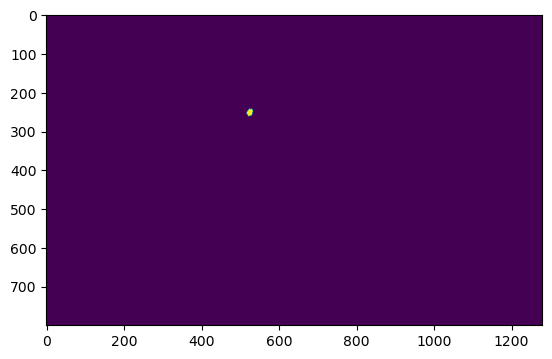

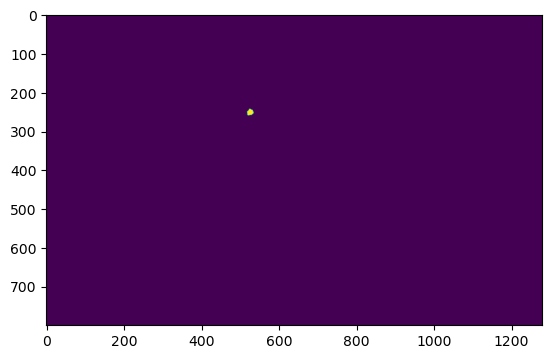

In [48]:
plt.imshow(cell_image_1)
plt.show()
plt.imshow(cell_image_2)
plt.show()

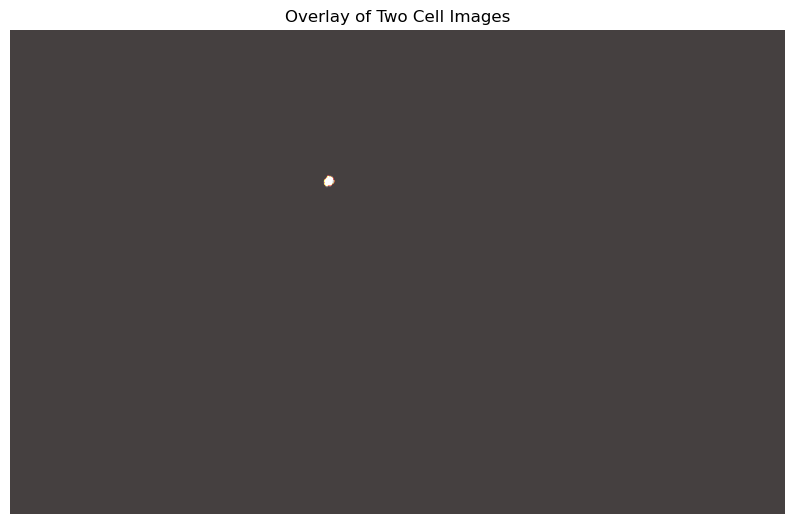

In [49]:
plt.figure(figsize=(10, 10))

# Display the first image
plt.imshow(cell_image_1, cmap='gray', alpha=0.5)

# Overlay the second image with transparency (alpha)
plt.imshow(cell_image_2, cmap='hot', alpha=0.5)

plt.title("Overlay of Two Cell Images")
plt.axis('off')  # Hide axes for better visualization
plt.show()

In [33]:
len(final_df)

674

In [35]:
df =  pd.DataFrame(final_df)

In [36]:
df.to_csv("Overlaps.csv")

In [48]:
unified_cells = {}  # key: unified_id, value: dict of map_id to cell_id
next_unified_id = 1  # Counter for assigning unified IDs
assigned_cells = {}

In [49]:
# For each map, we'll keep track of which cells have been assigned a unified ID
assigned_cells = {}  # key: (map_id, cell_id), value: unified_id

for map_id1 in cell_data:
    for cell_id1 in cell_data[map_id1]:
        # Skip if this cell has already been assigned a unified ID
        if (map_id1, cell_id1) in assigned_cells:
            continue
        mask1 = cell_data[map_id1][cell_id1]['mask']
        area1 = cell_data[map_id1][cell_id1]['area']
        
        best_match = None
        best_overlap = 0
        
        # Compare with cells in other maps
        for map_id2 in cell_data:
            if map_id2 <= map_id1:
                continue  # Avoid duplicate comparisons and self-comparison
            for cell_id2 in cell_data[map_id2]:
                mask2 = cell_data[map_id2][cell_id2]['mask']
                area2 = cell_data[map_id2][cell_id2]['area']
                
                # Calculate overlap percentages
                overlap_percent1, overlap_percent2 = calculate_overlap(mask1, mask2)
                
                # Check if overlap meets the 80% criterion for both cells
                if overlap_percent1 >= 0.8 and overlap_percent2 >= 0.8:
                    # Decide if this is the best match based on overlap area
                    overlap_area = overlap_percent1 * area1  # Could also use average or min of the two
                    if overlap_area > best_overlap:
                        best_overlap = overlap_area
                        best_match = (map_id2, cell_id2)
        
        # Assign unified IDs
        if best_match:
            # Check if the matched cell already has a unified ID
            if best_match in assigned_cells:
                unified_id = assigned_cells[best_match]
            else:
                unified_id = next_unified_id
                next_unified_id += 1
                assigned_cells[best_match] = unified_id
            assigned_cells[(map_id1, cell_id1)] = unified_id
        else:
            # No overlap found; assign a new unified ID
            unified_id = next_unified_id
            next_unified_id += 1
            assigned_cells[(map_id1, cell_id1)] = unified_id


In [50]:
import pandas as pd

# Initialize a dictionary to build the DataFrame
df_data = {}


In [51]:
for (map_id, cell_id), unified_id in assigned_cells.items():
    if unified_id not in df_data:
        df_data[unified_id] = {}
    df_data[unified_id][f'overlap_map{map_id}'] = cell_id


In [52]:
# Convert the dictionary to a DataFrame
df = pd.DataFrame.from_dict(df_data, orient='index')
df.index.name = 'unified_id'
df.reset_index(inplace=True)


In [53]:
df.to_csv('cell_overlap_info.csv', index=False)
print("DataFrame saved to 'cell_overlap_info.csv'")


DataFrame saved to 'cell_overlap_info.csv'


In [54]:
472+206

678

In [ ]:
total_num_cells = 